# Exploworing `pytorch-lightning` with `xaitk-saliency` Integration

This example extends the "PyTorch Lightning DataModules" notebook, found [here](https://github.com/Lightning-AI/tutorials/blob/publication/.notebooks/lightning_examples/datamodules.ipynb), for multi-GPU based training. Additionally, this notebook will explore integrating `xaitk-saliency` and `pytorch-lightning` to generate saliency maps for model predictions.

## Table of Contents

* [Environment Setup](#environment-setup)
* [Imports](#imports)
* [Model Preparation](#model-preparation)
  * [Defining the Dataset Agnostic `LitModel`](#defining-dataset-agnostic-lit-model)
  * [Defining the `CIFAR10DataModule`](#defining-cifar10-data-module)
  * [Training `LitModel` Using the `CIFAR10DataModule`](#training-lit-model-for-cifar10)
* [`xaitk-saliency` Integration](#xaitk-integration)
  * [High-Level API Integration](#high-level-api-integration)
    * [Defining the "Application"](#defining-the-application)
    * [Black-Box Classifier](#black-box-classifier)
    * [Saliency Generator](#saliency-generator)
    * [Calling the Application](#calling-the-application)
  * [Low-Level API Integration](#low-level-api-integration)
    * [Defining `LitSaliencyModel`](#defining-lit-saliency-model)
    * [Perturber and Saliency Generator](#perturber-and-saliency-generator)
    * [Saliency Generator](#saliency-generator)
    * [Generate Saliency Maps](#generate-saliency-maps)
  * [Results Comparison](#results-comparison)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/xaitk-jatic/blob/main/docs/examples/lightning/xaitk-lightning.ipynb)

## Environment Setup <a name="environment-setup"></a>

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/xaitk-jatic/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys  # noqa:F401

!{sys.executable} -m pip install -qU pip
print("Installing torchmetrics...")
!{sys.executable} -m pip install -q 'torchmetrics>=0.7'
print("Installing ipython...")
!{sys.executable} -m pip install -q ipython[notebook]
print("Installing setuptools...")
!{sys.executable} -m pip install -q setuptools
print("Installing torch...")
!{sys.executable} -m pip install -q 'torch>=1.8'
print("Installing pytorch-lightning...")
!{sys.executable} -m pip install -q 'pytorch-lightning>=1.6,<2.0'
print("Installing torchvision...")
!{sys.executable} -m pip install -q torchvision
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing matplotlib...")
!{sys.executable} -m pip install -q matplotlib
print("Done!")

Installing torchmetrics...
Installing ipython...
Installing setuptools...
Installing torch...
Installing pytorch-lightning...
Installing torchvision...
Installing xaitk-saliency...
Installing matplotlib...
Done!


## Imports <a name="imports"></a>

In [2]:
# For "artifact tracking" (to compare results)
import pickle
from collections.abc import Iterable, Iterator, Sequence
from typing import Any, Optional, Union

import matplotlib.pyplot as plt  # type: ignore

# xaitk-saliency integration imports
import numpy as np
import torch  # type: ignore
import torch.nn.functional as functional  # type: ignore
from pytorch_lightning import LightningDataModule, LightningModule, Trainer  # type: ignore
from pytorch_lightning.callbacks.progress.tqdm_progress import TQDMProgressBar  # type: ignore

# High-Level
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from torch import nn  # type: ignore
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset, IterableDataset, get_worker_info, random_split  # type: ignore
from torchmetrics.functional import accuracy  # type: ignore
from torchvision import transforms  # type: ignore

# Note you must have torchvision installed for this example
from torchvision.datasets import CIFAR10  # type: ignore
from typing_extensions import override

# Low-Level
from xaitk_saliency.impls.gen_classifier_conf_sal.occlusion_scoring import OcclusionScoring
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.impls.perturb_image.sliding_window import SlidingWindow
from xaitk_saliency.interfaces.gen_classifier_conf_sal import GenerateClassifierConfidenceSaliency
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency
from xaitk_saliency.interfaces.perturb_image import PerturbImage
from xaitk_saliency.utils.masking import occlude_image_batch, occlude_image_streaming

In [3]:
from lightning_fabric.utilities.seed import seed_everything  # type: ignore

# For reproducability
seed_everything(0, workers=True)

Global seed set to 0


0

## Model Preparation <a name="model-preparation"></a>

### Defining the Dataset Agnostic `LitModel` <a name="defining-dataset-agnostic-lit-model"></a>

Below we define the same `LitMNIST` model as was defined in [PyTorch Lightning's MNIST Hello World Notebook](https://github.com/Lightning-AI/tutorials/blob/publication/.notebooks/lightning_examples/mnist-hello-world.ipynb). However, we'll modify it to be data agnostic so we can use any input data we'd like. We'll also make some slight modifications to the model to ensure our model can scale without changes, as noted in [Lightning's documentation](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/accelerator_prepare.html).

Note: If the `ddp_notebook` or `ddp_fork` distributed mode is used, GPU operations such as moving tensors to the GPU or calling `torch.cuda` functions before invoking `Trainer.fit` are not allowed so we will avoid doing so.

In [ ]:
class LitModel(LightningModule):
    """
    A PyTorch Lightning module for training and evaluating a simple neural network classifier.

    Attributes:
        channels (int): Number of input channels in the data.
        width (int): Width of the input data.
        height (int): Height of the input data.
        num_classes (int): Number of output classes.
        hidden_size (int): Size of the hidden layer in the network.
        learning_rate (float): Learning rate for the optimizer.
        model (nn.Sequential): The neural network model.
    """

    def __init__(
        self,
        channels: int,
        width: int,
        height: int,
        num_classes: int,
        hidden_size: int = 64,
        learning_rate: float = 2e-4,
    ) -> None:
        """
        Initializes the LitModel.

        Args:
            channels (int): Number of input channels.
            width (int): Width of the input data.
            height (int): Height of the input data.
            num_classes (int): Number of output classes.
            hidden_size (int, optional): Hidden layer size. Defaults to 64.
            learning_rate (float, optional): Learning rate for the optimizer. Defaults to 2e-4.
        """
        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.channels = channels
        self.width = width
        self.height = height
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes),
        )

        self.save_hyperparameters()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output logits from the network.
        """
        return self.model(x)

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], _: int) -> torch.Tensor:
        """
        Performs a training step.

        Args:
            batch (Tuple[torch.Tensor, torch.Tensor]): A batch of data containing inputs and labels.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Training loss for the batch.
        """
        x, y = batch
        logits = self(x)
        return functional.cross_entropy(logits, y)

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], _: int) -> None:
        """
        Performs a validation step.

        Args:
            batch (Tuple[torch.Tensor, torch.Tensor]): A batch of data containing inputs and labels.
            batch_idx (int): Index of the batch.
        """
        x, y = batch
        logits = self(x)
        loss = functional.cross_entropy(logits, y)
        preds = torch.argmax(functional.softmax(logits, dim=1), dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=self.num_classes, top_k=1)
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        self.log("val_acc", acc, prog_bar=True, sync_dist=True)

    def predict_step(
        self,
        batch: torch.Tensor,
        batch_idx: int,  # noqa:ARG002
        dataloader_idx: int = 0,  # noqa:ARG002
    ) -> torch.Tensor:
        """
        Perform a prediction step on a batch of data.

        Args:
            batch (torch.Tensor):
                The input batch of data (e.g., images or feature tensors).
            batch_idx (int):
                Index of the current batch within an epoch.
            dataloader_idx (int, optional):
                Index of the dataloader, if multiple dataloaders are used.
                Defaults to 0.

        Returns:
            torch.Tensor:
                The output tensor of probabilities after applying softmax.
        """
        return functional.softmax(self(batch), dim=1)

    def configure_optimizers(self) -> Optimizer:
        """
        Configures the optimizer for training.

        Returns:
            torch.optim.Optimizer: The optimizer for training.
        """
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

### Defining the `CIFAR10DataModule` <a name="defining-cifar10-data-module"></a>

Here we define a new `DataModule` for the CIFAR10 dataset so that we can use our model to predict on CIFAR10 data. We've also added `get_transform()` and `get_classes()` as convenience methods to help us later when we integrate with `xaitk-saliency`.

In [5]:
BATCH_SIZE = 256
PREDICT_SIZE = 5
CHKPT_PATH = "cifar10.ckpt"

In [6]:
class CIFAR10DataModule(LightningDataModule):
    """
    A PyTorch Lightning DataModule for the CIFAR-10 dataset. Handles data preparation,
    setup for train/validation/test splits, and dataloader creation.

    Attributes:
        data_dir (str): Directory where CIFAR-10 data is stored or will be downloaded.
        transform (transforms.Compose): Data transformation pipeline for preprocessing.
        dims (Tuple[int, int, int]): Dimensions of the input images (channels, height, width).
        num_classes (int): Number of classes in the CIFAR-10 dataset.
        classes (List[str]): List of class labels.
        cifar_train (Optional[Dataset]): Training dataset split.
        cifar_val (Optional[Dataset]): Validation dataset split.
        cifar_test (Optional[Dataset]): Test dataset split.
        cifar_predict (Optional[Dataset]): Prediction dataset split.
    """

    def __init__(self, data_dir: str = "./") -> None:
        """
        Initializes the CIFAR10DataModule.

        Args:
            data_dir (str): Directory to store or download the CIFAR-10 dataset. Defaults to "./".
        """
        super().__init__()
        self.data_dir = data_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ],
        )

        self.dims = (3, 32, 32)
        self.num_classes = 10
        self.classes = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

    def prepare_data(self) -> None:
        """Downloads the CIFAR-10 dataset if not already available in the specified directory."""
        # download
        CIFAR10(self.data_dir, train=False, download=True)
        CIFAR10(self.data_dir, train=True, download=True)

    def setup(self, stage: Optional[str] = None) -> None:
        """
        Sets up datasets for training, validation, testing, and prediction.

        Args:
            stage (Optional[str]): The stage for which the datasets should be prepared. Can be "fit",
                "test", "predict", or None for all stages. Defaults to None.
        """
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(
                cifar_full,
                [45000, 5000],
                generator=torch.Generator().manual_seed(0),
            )

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage == "predict" or stage is None:
            cifar_full_test = CIFAR10(self.data_dir, train=False, transform=self.transform)
            if PREDICT_SIZE == -1 or len(cifar_full_test) <= PREDICT_SIZE:
                self.cifar_test = cifar_full_test
                self.cifar_predict = cifar_full_test
            else:
                test_size = len(cifar_full_test) - PREDICT_SIZE
                self.cifar_test, self.cifar_predict = random_split(
                    cifar_full_test,
                    [test_size, PREDICT_SIZE],
                    generator=torch.Generator().manual_seed(0),
                )

    def train_dataloader(self) -> DataLoader:
        """
        Creates a DataLoader for the training dataset.

        Returns:
            DataLoader: DataLoader for the training dataset.
        """
        return DataLoader(self.cifar_train, batch_size=BATCH_SIZE)

    def val_dataloader(self) -> DataLoader:
        """
        Creates a DataLoader for the validation dataset.

        Returns:
            DataLoader: DataLoader for the validation dataset.
        """
        return DataLoader(self.cifar_val, batch_size=BATCH_SIZE)

    def test_dataloader(self) -> DataLoader:
        """
        Creates a DataLoader for the test dataset.

        Returns:
            DataLoader: DataLoader for the test dataset.
        """
        return DataLoader(self.cifar_test, batch_size=BATCH_SIZE)

    def predict_dataloader(self) -> DataLoader:
        """
        Creates a DataLoader for the prediction dataset.

        Returns:
            DataLoader: DataLoader for the prediction dataset.
        """
        return DataLoader(self.cifar_predict, batch_size=BATCH_SIZE)

    def get_transform(self) -> transforms.Compose:
        """
        Returns the transformation pipeline applied to the dataset.

        Returns:
            transforms.Compose: The data transformation pipeline.
        """
        return self.transform

    def get_classes(self) -> list[str]:
        """
        Returns the list of class labels.

        Returns:
            List[str]: The list of class labels.
        """
        return self.classes

### Training `LitModel` using the `CIFAR10DataModule` <a name="training-lit-model-for-cifar10"></a>

Now that we've defined the `CIFAR10DataModule`, we can train our model. 

We've specified our [accelerator settings](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/gpu_basic.html) for training as `"auto"` to increase the portability of this notebook, but this and device count may need to be adjusted depending on hardware availability. Additionally, we've set our [scaling strategy](https://pytorch-lightning.readthedocs.io/en/latest/accelerators/gpu_intermediate.html) to `dp` due to the limitations of scaling strategies within interactive environments.

This model isn't very good, so it will perform badly on the CIFAR10 dataset. The point here is that we can see our `LitModel` has no problem using a different datamodule as its input data.

In [7]:
cifar10_dm = CIFAR10DataModule()
cifar10_model = LitModel(*cifar10_dm.dims, cifar10_dm.num_classes, hidden_size=256)
tqdm_progress_bar = TQDMProgressBar(refresh_rate=20)
cifar10_trainer = Trainer(
    max_epochs=5,
    accelerator="auto",
    devices="auto",
    callbacks=[tqdm_progress_bar],
)
cifar10_trainer.fit(cifar10_model, cifar10_dm)

/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dep

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 855 K 
-------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.420     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


We'll save our training so we can reuse this checkpoint later.

In [8]:
cifar10_trainer.save_checkpoint(CHKPT_PATH)

## `xaitk-saliency` Integration <a name="xaitk-integration"></a>

`xaitk-saliency`'s high-level API provides a convenient way of integrating with PyTorch Lightning, but it doesn't take full advantage of Lightning's scalability. `xaitk-saliency`'s low-level API requires more effort to set up, but can allow us to take advantage of Lightning's scalability throughout the entire saliency map generation process across a dataset. We'll explore both here.

### High-Level API Integration <a name="high-level-api-integration"></a>

#### Defining the "Application" <a name="defining-the-application"></a>

Our "application" will accept a set of images, a black-box image classifier, and a saliency generator. It will generate and plot saliency maps for each image provided.

In [9]:
def app(  # noqa:C901
    images: np.ndarray,
    image_classifier: ClassifyImage,
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    display_results: bool = True,
    results_filepath: Optional[str] = None,
) -> None:
    """
    Generates saliency maps for a set of images, visualizes them, and optionally saves the results.

    Args:
        images (np.ndarray): A numpy array of input images.
        image_classifier (ClassifyImage): An object implementing classification and label retrieval.
        saliency_generator (GenerateImageClassifierBlackboxSaliency):
            A callable for generating saliency maps for images.
        display_results (bool, optional): Whether to display saliency maps for each image. Defaults to True.
        results_filepath (Optional[str], optional): Filepath to save the saliency maps. Defaults to None.

    Returns:
        None
    """
    # Generate saliency maps
    sal_maps_set = []
    for img in images:
        sal_maps = saliency_generator(img, image_classifier)
        sal_maps_set.append(sal_maps)

    # Get class labels
    labels = image_classifier.get_labels()
    num_classes = len(labels)

    # Plot each image in set with saliency maps
    if display_results:
        for i in range(len(images)):
            plt.figure(figsize=(10, 5))
            num_cols = np.ceil(num_classes / 2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow(images[i], cmap="gray")
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")
            for c in range(num_classes - num_cols + 1, num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")

    # Save results for comparison for examples sake
    if results_filepath is not None:
        with open(results_filepath, "wb") as file:
            pickle.dump(sal_maps_set, file)

#### Black-Box Classifier <a name="black-box-classifier"></a>

To use the selected model with the `GenerateImageClassifierBlackboxSaliency` interface, we need to create an implementation of `ClassifyImage` that wraps the underlying model. The core method that requires implementation is `classify_images()` which takes images and returns predictions for each image in the format defined by the interface.

Since PyTorch Lightning expects data to be provided via a dataloader for scaling purposes, we also define an `IterableDataset` that we'll use to satisfy this requirement.

In [10]:
class PytorchLightningClassifier(ClassifyImage):
    """
    A PyTorch Lightning-based classifier for image classification tasks. Extends the `ClassifyImage` interface.

    Attributes:
        trainer (Trainer): The PyTorch Lightning Trainer object for model training and inference.
        labels (List[str]): List of class labels.
        transform (Optional[callable]): An optional transform to apply to the input images.
        model (Optional[LightningModule]): A PyTorch Lightning module for the classification model.
    """

    def __init__(
        self,
        trainer: Trainer,
        labels: list[str],
        transform: Optional[transforms.Compose] = None,
        model: Optional[LightningModule] = None,
    ) -> None:
        """
        Initializes the classifier with a trainer, labels, an optional transform, and an optional model.

        Args:
            trainer (Trainer): The PyTorch Lightning Trainer object.
            labels (List[str]): A list of class labels.
            transform (Optional[callable], optional): A transform function to preprocess input images.
                                                      Defaults to None.
            model (Optional[LightningModule], optional): A PyTorch Lightning module for classification.
                                                         Defaults to None.
        """
        self.trainer = trainer
        self.labels = labels
        self.transform = transform
        self.model = model

    @override
    def get_labels(self) -> list[str]:
        return self.labels

    class ClassifyImagesDataset(IterableDataset):
        """
        A custom dataset for classifying images, supporting distributed workers.

        Attributes:
            iterable (Iterable[np.ndarray]): An iterable providing input images.
            batch_size (int): The batch size for processing.
            transform (Optional[callable]): An optional transform to preprocess images.
        """

        def __init__(
            self,
            iterable: Iterable[np.ndarray],
            batch_size: int,
            transform: Optional[transforms.Compose] = None,
        ) -> None:
            """
            Initializes the dataset with an iterable, batch size, and an optional transform.

            Args:
                iterable (Iterable[np.ndarray]): The input image iterable.
                batch_size (int): The batch size for processing.
                transform (Optional[callable], optional): A transform function to preprocess images.
                                                        Defaults to None.
            """
            self._iterable = iterable
            self._batch_size = batch_size
            self._transform = transform

        def __iter__(self) -> Iterator[np.ndarray]:
            """
            Iterates through the dataset, applying transformations and handling distributed workers.

            Returns:
                Iterable[np.ndarray]: An iterable of preprocessed images.
            """
            tnsfm = self._transform
            batch_size = self._batch_size

            worker_info = get_worker_info()
            worker_id = worker_info.id if worker_info else None
            worker_count = int(worker_info.num_workers) if worker_info else None

            for i, image in enumerate(self._iterable):
                # worker things -- "my" batch when
                # `(i // batch_size) % num_workers == worker_id`, otherwise skip
                # that `i`.
                if worker_info is None or (worker_count is not None and (i // batch_size) % worker_count == worker_id):
                    yield tnsfm(image) if tnsfm else image

    @override
    def classify_images(self, img_iter: Iterable[np.ndarray]) -> Iterator[dict[str, float]]:
        dataloader = DataLoader(
            self.ClassifyImagesDataset(img_iter, BATCH_SIZE, self.transform),
            batch_size=BATCH_SIZE,
            num_workers=4,
            shuffle=False,
        )
        if self.model is None:
            preds = self.trainer.predict(ckpt_path=CHKPT_PATH, dataloaders=dataloader)
        else:
            preds = self.trainer.predict(ckpt_path=CHKPT_PATH, model=self.model, dataloaders=dataloader)
        if preds is None:
            yield dict.fromkeys(self.labels, 0.0)
            return
        for batch in preds:
            for pred in batch:
                yield {la: p for p, la in zip(pred, self.labels)}

    # Required for implementation
    @override
    def get_config(self) -> dict[str, Any]:
        return {}


cifar10_classifier = PytorchLightningClassifier(
    cifar10_trainer,
    cifar10_dm.get_classes(),
    transform=cifar10_dm.get_transform(),
)

#### Saliency Generator <a name="saliency-generator"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image pertubation and heatmap generation.

In [11]:
gen_sliding_window = SlidingWindowStack(window_size=(2, 2), stride=(1, 1), threads=4)
gen_sliding_window.fill = (128, 128, 128)

#### Image Samples <a name="image-samples"></a>

Here we'll select our image samples for example's sake and ensure the data is in the proper format for our black-box image classifier.

In [12]:
cifar10_dm.setup(stage="predict")
predict_subset = cifar10_dm.cifar_predict
cifar_predict_arr = predict_subset.dataset.data[predict_subset.indices]  # type: ignore

#### Calling the Application <a name="calling-the-application"></a>

We know our model doesn't perform well on this dataset and these results confirm that the model has difficulty discriminating between CIFAR10 classes. It's not clear which features the model is trying to focus on, if it is able to identify any at all, for many of the samples.

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This li

Predicting: 176it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt


Predicting: 176it [00:00, ?it/s]

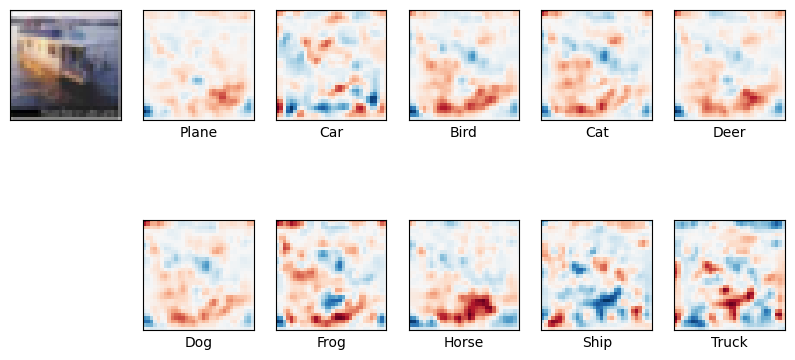

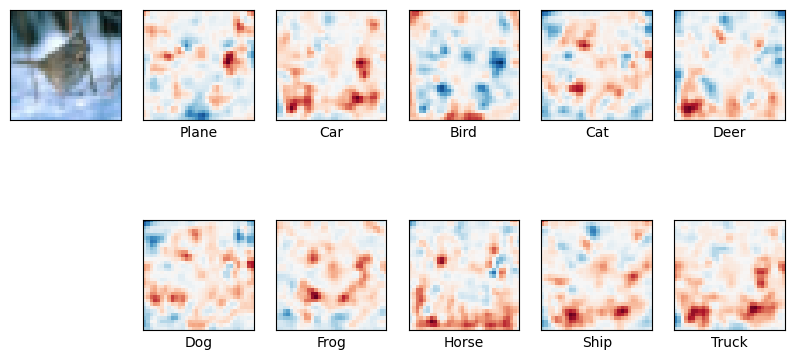

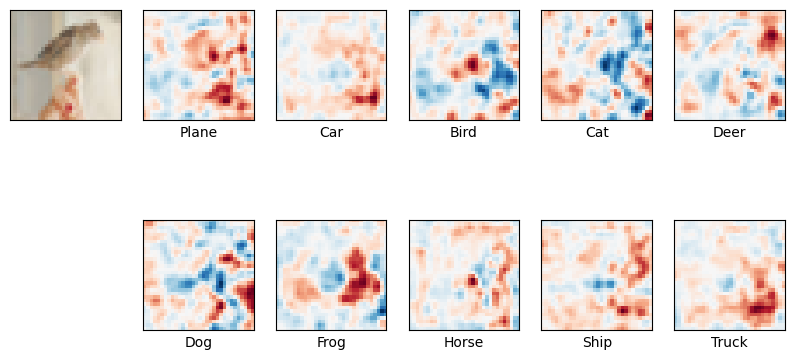

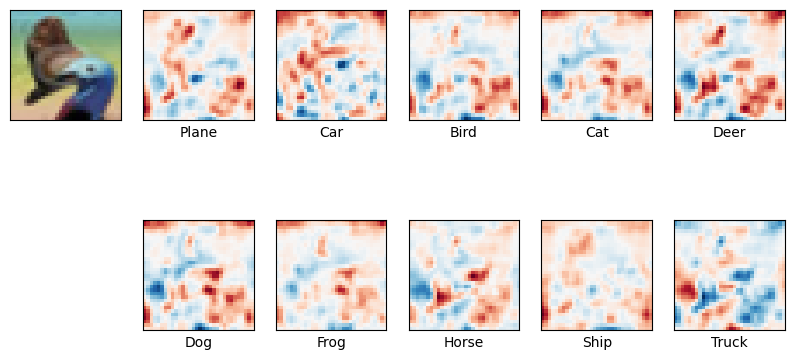

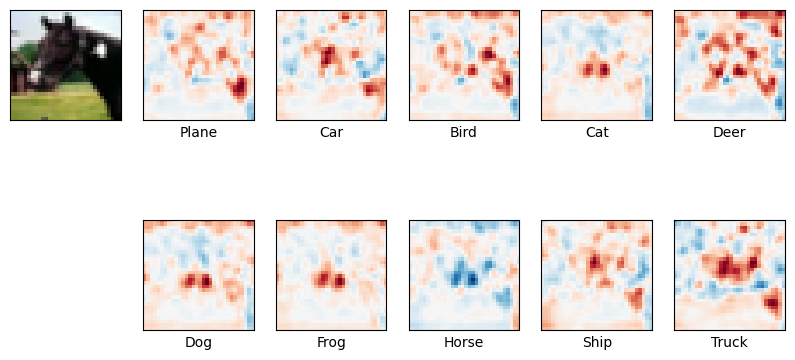

In [30]:
app(cifar_predict_arr, cifar10_classifier, gen_sliding_window, results_filepath="high_level.pkl")

### Low-Level API Integration <a name="low-level-api-integration"></a>

#### Defining `LitSaliencyModel` <a name="defining-lit-saliency-model"></a>

Here we will define `LitSaliencyModel` which overrides the `predict_step` function of `LitModel` to add saliency map generation for each image that we predict on. The "driver" of this added functionality is `gen_saliency_maps(ref_preds, imgs)`.

To generate saliency maps, we'll need a pertubation implementation and a saliency generator.

Within `gen_saliency_maps(..)`, there are 3 main steps:
1. Generate perturbed data via the perturber
2. Predict upon the perturbed data
3. Using these prediction results, the saliency generator will generate heat maps

**Note:** When integrated within PyTorch Lightning like this or in a similar manner, saliency map operations take place on pre-processed tensors instead of raw input images. Certain details may need to be adjusted compared to a high-level integration. For example, here we won't explicitly set a fill value because our data will be pre-processed such that the grey value would be zeros.

In [ ]:
class LitSaliencyModel(LitModel):
    """
    A PyTorch Lightning module for generating and visualizing saliency maps for a classifier.
    Extends the `LitModel` class to include perturbation-based saliency generation.

    Attributes:
        perturber (PerturbImage): An object to generate perturbation masks for saliency mapping.
        generator (GenerateClassifierConfidenceSaliency): A saliency generator for calculating saliency maps.
        labels (Sequence[Hashable]): A sequence of labels for the classes.
        process (str): Processing type for generating perturbed images ("batch" or "stream").
        threads (int): Number of threads to use for parallel processing.
        display_results (bool): Whether to display saliency map visualizations.
        results_filepath (Optional[str]): Path to save generated saliency maps.
    """

    def __init__(
        self,
        channels: int,
        width: int,
        height: int,
        num_classes: int,
        perturber: PerturbImage,
        saliency_generator: GenerateClassifierConfidenceSaliency,
        labels: Sequence[int] = [],
        hidden_size: int = 64,
        learning_rate: float = 2e-4,
        process: str = "batch",
        threads: int = 4,
        display_results: bool = True,
        results_filepath: Optional[str] = None,
    ) -> None:
        """
        Initializes the LitSaliencyModel.

        Args:
            channels (int): Number of input channels.
            width (int): Input image width.
            height (int): Input image height.
            num_classes (int): Number of output classes.
            perturber (PerturbImage): Object to generate perturbation masks.
            saliency_generator (GenerateClassifierConfidenceSaliency): Saliency map generator.
            labels (Sequence[Hashable], optional): Class labels. Defaults to an empty list.
            hidden_size (int, optional): Hidden size of the model. Defaults to 64.
            learning_rate (float, optional): Learning rate for training. Defaults to 2e-4.
            process (str, optional): Type of processing ("batch" or "stream"). Defaults to "batch".
            threads (int, optional): Number of threads for parallel processing. Defaults to 4.
            display_results (bool, optional): Display saliency maps. Defaults to True.
            results_filepath (Optional[str], optional): Filepath to save saliency maps. Defaults to None.
        """
        super().__init__(
            channels,
            width,
            height,
            num_classes,
            hidden_size,
            learning_rate,
        )

        self.perturber = perturber
        self.generator = saliency_generator
        self.labels = labels
        if not self.labels:
            self.labels = list(range(self.num_classes))

        self.process = process
        self.threads = threads
        # Optional fill color
        self.fill: Optional[Union[int, Sequence[int]]] = None
        self.display_results = display_results
        self.results_filepath = results_filepath

    def predict_step(self, batch: torch.Tensor, batch_idx: int, dataloader_idx: int = 0) -> torch.Tensor:
        """
        Predicts the outputs for a batch and generates saliency maps.

        Args:
            batch (Any): The input batch.
            batch_idx (int): The batch index.
            dataloader_idx (int, optional): The dataloader index. Defaults to 0.

        Returns:
            Any: The predictions for the batch.
        """

        if isinstance(batch, list):
            x, _ = batch
        else:
            x = batch

        preds = super().predict_step(x, batch_idx, dataloader_idx)
        # Generate saliency maps for every input
        self._gen_saliency_maps(preds.unsqueeze(1), x)

        return preds

    def _gen_saliency_maps(self, ref_preds: torch.Tensor, imgs: torch.Tensor) -> None:
        """
        Generates saliency maps for a set of images and their predictions.

        Args:
            ref_preds (List[np.ndarray]): List of reference predictions for the images.
            imgs (List[np.ndarray]): List of input images.

        Returns:
            None
        """
        sal_maps_set = []
        ref_imgs = []
        for ref_pred, img in zip(ref_preds, imgs):
            # Lightning data is channel first
            ref_img = np.moveaxis(img.cpu().data.numpy(), 0, 2)
            ref_imgs.append(ref_img)

            # Generate pertubation masks
            pert_masks = self.perturber(ref_img)
            # Confidence value setup
            ref_conf_dict = list(self._classify_preds([ref_pred]))[0]
            ref_conf_vec = np.asarray([ref_conf_dict[la] for la in self.labels])
            pert_conf_mat = np.empty((pert_masks.shape[0], ref_conf_vec.shape[0]), dtype=ref_conf_vec.dtype)

            # Generate perturbed images
            pert_imgs_it = self._gen_perturbed_imgs(ref_img, pert_masks)

            # Predict on perturbed images
            pert_outputs = []
            dataloader = DataLoader(self._MaskDataset(pert_imgs_it, imgs), shuffle=False, batch_size=BATCH_SIZE)
            pert_outputs = [(functional.softmax(self(batch), dim=1)) for batch in dataloader]
            pert_conf_it = self._classify_preds(pert_outputs)

            # Format confidence values for generator
            for i, pc in enumerate(pert_conf_it):
                pert_conf_mat[i] = [pc[la] for la in self.labels]

            # Generate saliency map
            sal_maps_set.append(
                self.generator(
                    ref_conf_vec,
                    pert_conf_mat,
                    pert_masks,
                ),
            )

        # Save saliency map for comparison for examples sake
        # Could be replaced by artifact tracking
        if self.results_filepath is not None:
            with open(self.results_filepath, "wb") as file:
                pickle.dump(sal_maps_set, file)

        # Plot each image in set with saliency maps
        if self.display_results:
            self._plot_saliency_maps(sal_maps_set, ref_imgs)

    class _MaskDataset(Dataset):
        """Dataset class for managing perturbed images and their associated references."""

        def __init__(self, imgs: list[np.ndarray], ref_tensor: Optional[torch.Tensor] = None) -> None:
            """
            Initializes the _MaskDataset.

            Args:
                imgs (List[np.ndarray]): List of perturbed images.
                ref_tensor (Optional[Any], optional): Reference tensor for type conversion. Defaults to None.
            """
            self.imgs = imgs
            self.to_tensor = transforms.ToTensor()
            self.ref_tensor = ref_tensor

        def __len__(self) -> int:
            """Returns the number of perturbed images."""
            return len(self.imgs)

        def __getitem__(self, index: int) -> np.ndarray:
            """
            Retrieves a perturbed image and converts it to a tensor.

            Args:
                index (int): Index of the image.

            Returns:
                np.ndarray: Converted image tensor.
            """
            img = self.to_tensor(self.imgs[index])
            if self.ref_tensor is not None:
                img = img.type_as(self.ref_tensor)
            return img

    def _gen_perturbed_imgs(self, ref_img: np.ndarray, pert_masks: np.ndarray) -> list[np.ndarray]:
        """
        Generates perturbed images using the specified process type.

        Args:
            ref_img (np.ndarray): Reference image.
            pert_masks (np.ndarray): Perturbation masks.

        Returns:
            Union[List[np.ndarray], Any]: Iterator or list of perturbed images.
        """
        if self.process == "stream":
            pert_imgs_it = occlude_image_streaming(ref_img, pert_masks, fill=self.fill, threads=self.threads)
        elif self.process == "batch":
            pert_imgs_it = occlude_image_batch(ref_img, pert_masks, fill=self.fill, threads=self.threads)
        else:
            raise ValueError(f"Unknown generate perturbed images process type: {self.process}")

        return pert_imgs_it

    def _classify_preds(self, preds: list[torch.Tensor]) -> list[dict[int, Any]]:
        """
        Classifies predictions into confidence scores for each label.

        Args:
            preds (List[torch.Tensor]): List of predictions from the model.

        Returns:
            List[dict]: List of dictionaries with confidence scores for each label.
        """
        results = []
        for batch in preds:
            for pred in batch:
                r = {}
                for p, la in zip(pred, self.labels):
                    r[la] = np.float32(p.item())
                results.append(r)

        return results

    def _plot_saliency_maps(self, sal_maps_set: list[np.ndarray], ref_imgs: list[np.ndarray]) -> None:
        """
        Plots saliency maps for visualization.

        Args:
            sal_maps_set (List[np.ndarray]): List of saliency maps.
            ref_imgs (List[np.ndarray]): List of reference images.

        Returns:
            None
        """
        for i in range(len(sal_maps_set)):
            plt.figure(figsize=(10, 5))
            num_cols = np.ceil(self.num_classes / 2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow((ref_imgs[i] + 1) / 2, cmap="gray")
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{self.labels[c]}")
            for c in range(self.num_classes - num_cols + 1, self.num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)  # type: ignore
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{self.labels[c]}")

#### Perturber and Saliency Generator <a name="perturber-and-saliency-generator"></a>

We create an instance of `SlidingWindow`, an implementation of the `PerturbImage` interface, to carry out our image pertubation and an instance of `OcclusionScoring`, an implementation of the `GenerateClassifierConfidenceSaliency` interface, for heatmap generation.

In [42]:
sliding_window_perturber = SlidingWindow(
    window_size=(2, 2),
    stride=(1, 1),
)
sal_map_generator = OcclusionScoring()

#### Generate Saliency Maps <a name="generate-saliency-maps"></a>

With our new `LitSaliencyModel`, we just have to call predict on our trained model to generate saliency maps across all predicted images. We'll load weights from our saved checkpoint so we don't need to train again.

/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature

Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA RTX A3000 12GB Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at cifar10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar10.ckpt
/home/local/KHQ/alexander.lynch/anaconda3/envs/xaitk-jatic/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

torch.Size([5, 10])


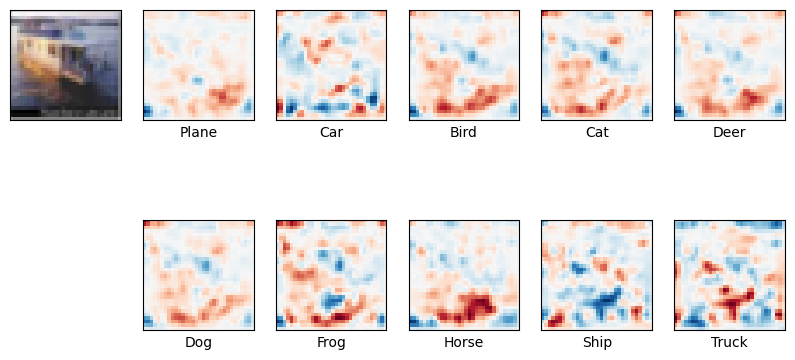

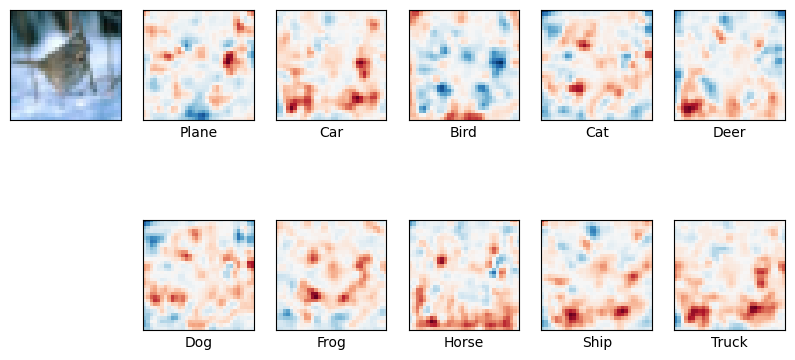

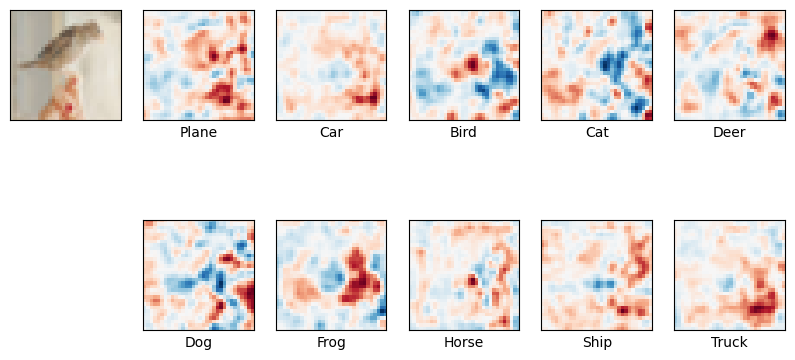

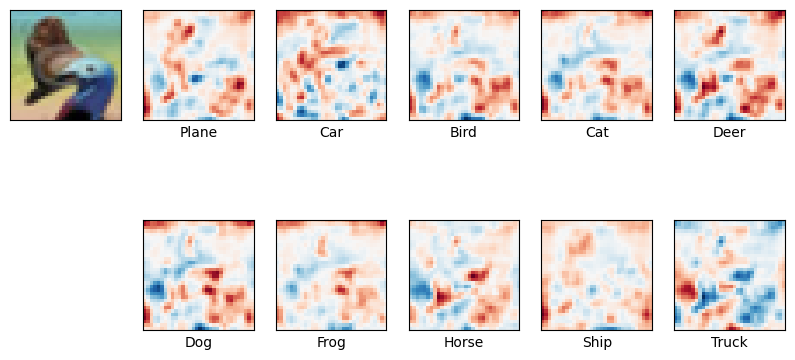

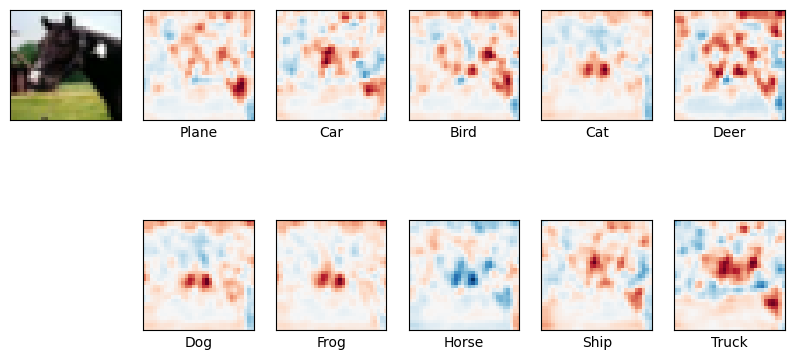

In [43]:
cifar10_model_low_level = LitSaliencyModel.load_from_checkpoint(
    perturber=sliding_window_perturber,
    saliency_generator=sal_map_generator,
    labels=cifar10_dm.get_classes(),
    results_filepath="low_level.pkl",
    checkpoint_path=CHKPT_PATH,
)
cifar10_trainer_low_level = Trainer(
    max_epochs=5,
    accelerator="auto",
    # NOTE: Limiting devices here so we can compare results more easily
    devices=1 if torch.cuda.is_available() else "auto",
    callbacks=[tqdm_progress_bar],
)
preds = cifar10_trainer_low_level.predict(model=cifar10_model_low_level, datamodule=cifar10_dm, ckpt_path=CHKPT_PATH)

### Results Comparison <a name="results-comparison"></a>

We can see via visual inspection that the saliency maps produced are consistent across both the high- and low-level methods, as expected. We can also confirm this numerically:

In [44]:
import joblib

low_level = joblib.load("low_level.pkl")
high_level = joblib.load("high_level.pkl")

allclose = [True] * len(low_level)
for idx, compare in enumerate(zip(low_level, high_level)):
    for low, high in zip(compare[0], compare[1]):
        # Normalize data
        low = (low - np.min(low)) / (np.max(low) - np.min(low))
        high = (high - np.min(high)) / (np.max(high) - np.min(high))

        if not np.allclose(low, high, atol=1e-02):
            allclose[idx] = False
            break
print(allclose)
if not all(allclose):
    raise ValueError("all(allclose) needs to be True")

[True, True, True, True, True]
